In [44]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import datetime as dt
import pandas as pd 
import matplotlib.dates as mdates

In [46]:
def fetch_data(ticker, start_date="2010-01-01"):
    end_date = dt.datetime.now().strftime('%Y-%m-%d')  
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close']
appl_data = fetch_data('NVDA')
print(appl_data)


[*********************100%***********************]  1 of 1 completed

Date
2010-01-04      0.462250
2010-01-05      0.469000
2010-01-06      0.472000
2010-01-07      0.462750
2010-01-08      0.463750
                 ...    
2024-08-22    123.739998
2024-08-23    129.369995
2024-08-26    126.459999
2024-08-27    128.300003
2024-08-28    125.610001
Name: Close, Length: 3688, dtype: float64


In [48]:
# Normalize and prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
aapl_scaled = scaler.fit_transform(appl_data.values.reshape(-1, 1))

# Function to create data sequences for LSTM training
def create_dataset(data, look_back=100):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y).reshape(-1, 1)

# Creating the dataset for training
X, Y = create_dataset(aapl_scaled)

# Splitting data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))


In [50]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(100, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with validation data
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0039 - val_loss: 2.3128e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.4257e-04 - val_loss: 2.0834e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.3476e-04 - val_loss: 2.5646e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.9702e-04 - val_loss: 1.9303e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.1986e-04 - val_loss: 1.2903e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.2432e-04 - val_loss: 1.1625e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.1885e-04 - val_loss: 1.1322e-04
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.6182e-04 - val_loss: 1.8454e-04
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.4896e-04 - val_loss: 1.0485e-04
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.1077e-04 - val_loss: 1.0726e-04
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.1535e-04 - 

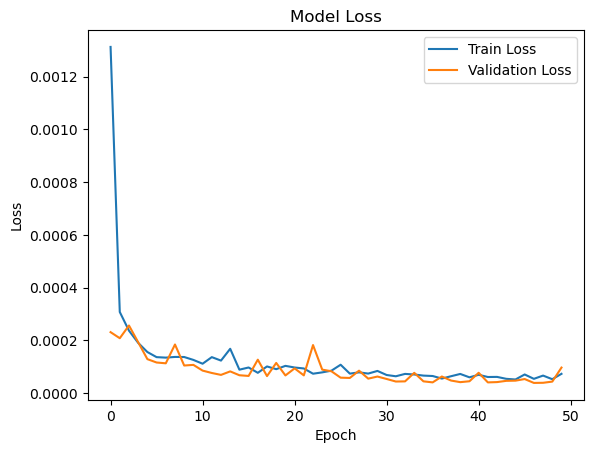

In [54]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


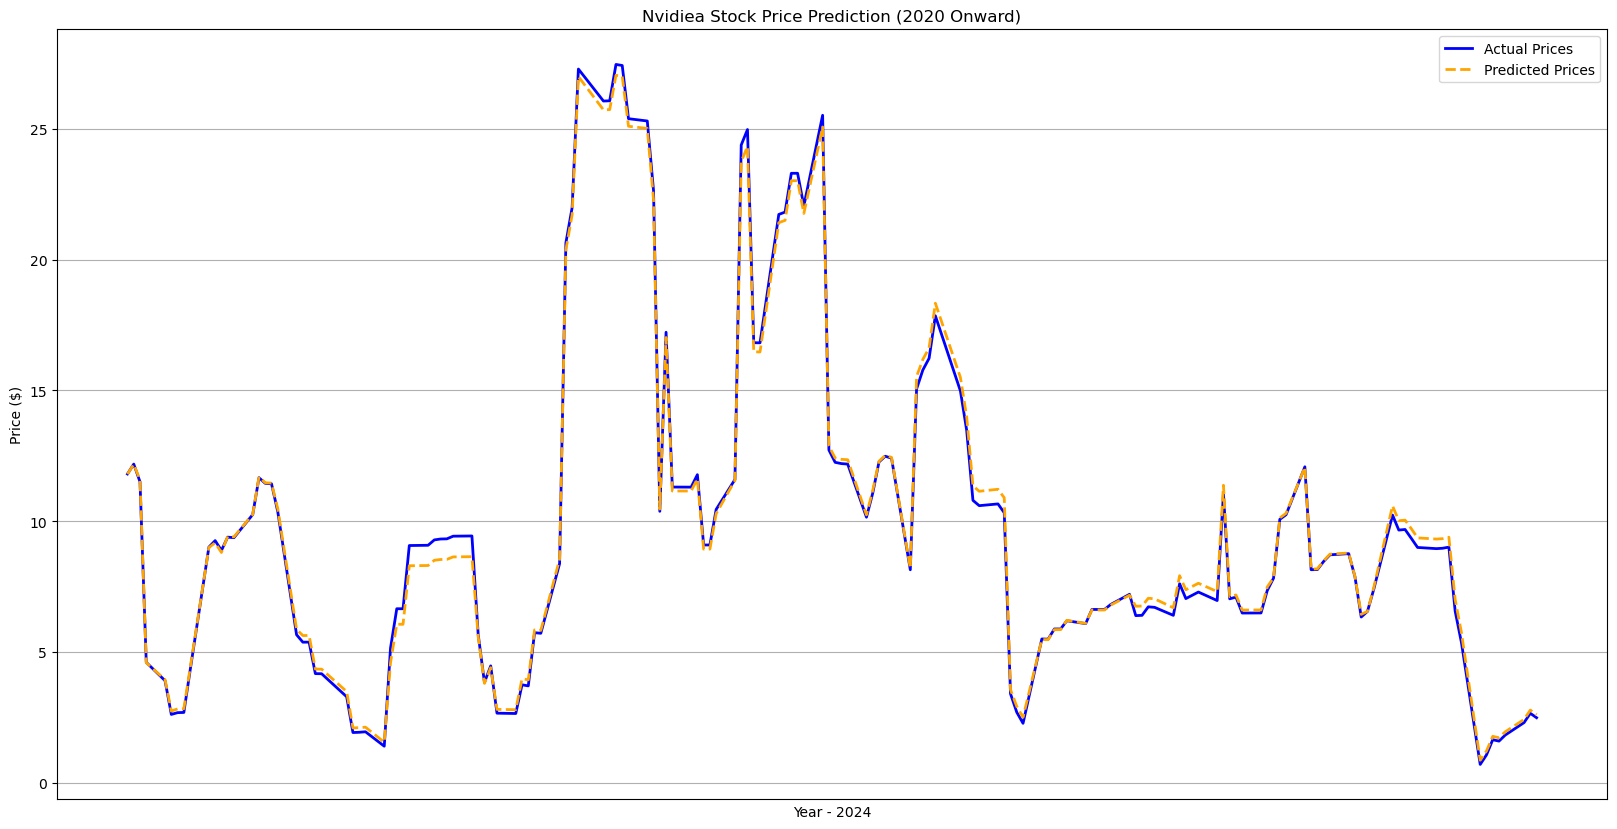

In [68]:
# Generate predictions for both training and validation data
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)

# Inverse scaling to transform predictions back to original scale
train_predictions = scaler.inverse_transform(train_predictions)
val_predictions = scaler.inverse_transform(val_predictions)
actual_train = scaler.inverse_transform(Y_train)
actual_val = scaler.inverse_transform(Y_val)

# Combining train and validation sets to plot them in context
all_predictions = np.concatenate((train_predictions.flatten(), val_predictions.flatten()))
all_actual = np.concatenate((actual_train.flatten(), actual_val.flatten()))

# Create the full timeline of dates for both training and validation periods
combined_dates = appl_data.index[-len(all_actual):]  

# Filter data to only include from 2024 onwards
mask = combined_dates >= "2024-01-01"
filtered_dates = combined_dates[mask]
filtered_actual = all_actual[mask]
filtered_predictions = all_predictions[mask]

# Plotting the actual prices and the predictions with years on x-axis
plt.figure(figsize=(20, 10))

# Smoothing the lines by plotting the rolling mean
rolling_window_size = 10  # Defines the window for rolling mean
smoothed_actual = pd.Series(filtered_actual).rolling(window=rolling_window_size).mean()
smoothed_predictions = pd.Series(filtered_predictions).rolling(window=rolling_window_size).mean()

# Plotting with thicker lines for better visibility
plt.plot(filtered_dates, smoothed_actual, label='Actual Prices', linestyle='-', color='blue', linewidth=2)  # Increased linewidth
plt.plot(filtered_dates, smoothed_predictions, label='Predicted Prices', linestyle='--', color='orange', linewidth=2)  # Increased linewidth

# Formatting the x-axis to show years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show year only
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Tick every year

plt.title('Nvidiea Stock Price Prediction (2020 Onward)')
plt.xlabel('Year - 2024')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


In [70]:
days_to_predict = 2


latest_data = aapl_scaled[-100:]  

future_predictions = []

# Predicting future stock prices day by day
for _ in range(days_to_predict):

    latest_data_reshaped = latest_data.reshape((1, latest_data.shape[0], 1))
    
    next_day_prediction = model.predict(latest_data_reshaped)
    
    # Inverse scale the prediction to get the actual price
    next_day_prediction_actual = scaler.inverse_transform(next_day_prediction)
    
    # Store the prediction
    future_predictions.append(next_day_prediction_actual[0, 0])
    
    # Update the latest data by adding the new prediction and removing the oldest point
    latest_data = np.append(latest_data, next_day_prediction)[1:]

# Display the predicted prices for the next two days
print("Predicted stock prices for the next two days:")
for i, price in enumerate(future_predictions, 1):
    print(f"Day {i}: ${price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted stock prices for the next two days:
Day 1: $127.10
Day 2: $127.50
